In [1]:
from fastai.vision.all import *
import timm
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from typing import List
from sklearn.model_selection import train_test_split
import kornia as K
import warnings
warnings.filterwarnings('ignore')

In [2]:
img_dir = '/mnt/data/flowers'

In [3]:
class ClassificationDataset(Dataset):
    def __init__(self, xs, ys, augs):
        self.xs = xs
        self.ys = L(ys).map(self.enc)
        self.augs = augs
        
    @classmethod    
    def from_imagenet(cls, root, augs: List):
        fs = get_image_files(img_dir)
        ys = fs.map(lambda x: x.parent.name)
        cls.c = len(ys.unique())
        classes = ys.unique().sorted()
        cls.enc = {j:i for i,j in enumerate(classes)}
        cls.rev_enc = {j:i for i,j in cls.enc.items()}
        x_train, x_val, y_train, y_val = train_test_split(fs, ys, 
                                                           random_state=2021, test_size=0.2)
        return cls(x_train, y_train, augs[0]), cls(x_val, y_val, augs[1])
    
    def __getitem__(self, idx):
        img = np.array(Image.open(self.xs[idx]).convert('RGB'))
        img = self.augs(image=img)['image']
        return img, torch.tensor(self.ys[idx])
    
    def __len__(self): return len(self.xs)

In [4]:
def get_light_augmentations(img_sz):
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                           rotate_limit=15,
                           border_mode= cv2.BORDER_REFLECT, value=0),
        A.RandomResizedCrop(img_sz, img_sz, 
                            scale = (0.65, 1.1),
                            p=1),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.25,
                                       contrast_limit=0.2),
            A.NoOp()]),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])

def val_augmentations(img_sz):
    return A.Compose([A.Resize(img_sz, img_sz, p=1),
                      ToTensorV2()])

In [5]:
def plot_sample(o, n: int=5):
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    for k, ax in enumerate(axes.ravel()):
        x, y = random.choice(o)
        ax.imshow(x.permute(1, 2, 0))
        ax.set_title(o.rev_enc[y.item()])
        ax.axis('off')
    plt.show()
#         ax.subplots_adjust(wspace=None, hspace=None)

In [6]:
def get_model(name, c):
    return nn.Sequential(*list(timm.create_model(name, pretrained=True, num_classes=c).children()))

In [7]:
class ImgProcCB(Callback):
    def before_batch(self):
        xb = K.normalize(self.xb[0]/255.0, 
                         mean=torch.tensor((0.485, 0.456, 0.406)), 
                         std=torch.tensor((0.229, 0.224, 0.225)))
        self.learn.xb = (xb,)

In [19]:
class PredictionDynamics(Callback):
    order, run_valid = 70, True

    def __init__(self, show_perc=1., figsize=(6, 6), alpha=.3, size=30, color='lime', cmap='gist_rainbow'):

        """
        Args:
            show_perc:  percent of samples from the valid set that will be displayed. Default: 1 (all).
                        You can reduce it if the number is too high and the chart is too busy.
            alpha:      level of transparency. Default:.3. 1 means no transparency.
            figsize:    size of the chart. You may want to expand it if too many classes.
            size:       size of each sample in the chart. Default:30. You may need to decrease it a bit if too many classes/ samples.
            color:      color used in regression plots.
            cmap:       color map used in classification plots.

        The red line in classification tasks indicate the average probability of true class.
        """

        store_attr("show_perc,figsize,alpha,size,color,cmap")

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run:
            return
        self.cat = True if (hasattr(self.dls, "c") and self.dls.c > 1) else False
        if self.show_perc != 1:
            valid_size = len(self.dls.valid.dataset)
            self.show_idxs = np.random.choice(valid_size, int(round(self.show_perc * valid_size)), replace=False)

        # Prepare ground truth container
        self.y_true = []
        assert hasattr(self.learn, 'progress')

    def before_epoch(self):
        # Prepare empty pred container in every epoch
        self.y_pred = []

    def after_pred(self):
        if self.training:
            return

        # Get y_true in epoch 0
        if self.epoch == 0:
            self.y_true.extend(self.y.cpu().flatten().numpy())

        # Gather y_pred for every batch
        if self.cat:
            y_pred = torch.gather(F.softmax(self.pred.detach().cpu(), 1), -1, self.y.cpu().reshape(-1, 1).long())
        else:
            y_pred = self.pred.detach().cpu()
        self.y_pred.extend(y_pred.flatten().numpy())

    def after_epoch(self):
        # Ground truth
        if self.epoch == 0:
            self.y_true = np.array(self.y_true)
            if self.show_perc != 1:
                self.y_true = self.y_true[self.show_idxs]
            self.y_bounds = (np.min(self.y_true), np.max(self.y_true))
            self.min_x_bounds, self.max_x_bounds = np.min(self.y_true), np.max(self.y_true)

        self.y_pred = np.array(self.y_pred)
        if self.show_perc != 1:
            self.y_pred = self.y_pred[self.show_idxs]
        if self.cat:
            self.update_graph(self.y_pred, self.y_true)
        else:
            # Adjust bounds during validation
            self.min_x_bounds = min(self.min_x_bounds, np.min(self.y_pred))
            self.max_x_bounds = max(self.max_x_bounds, np.max(self.y_pred))
            x_bounds = (self.min_x_bounds, self.max_x_bounds)
            self.update_graph(self.y_pred, self.y_true, x_bounds=x_bounds, y_bounds=self.y_bounds)

    def after_fit(self):
        plt.close(self.graph_ax.figure)

    def update_graph(self, y_pred, y_true, x_bounds=None, y_bounds=None):
        if not hasattr(self, 'graph_fig'):
            if self.cat:
                self._cl_names = self.dls.enc.keys()
                self._classes = L(self.dls.enc.values())
                self._n_classes = len(self._classes)
                self._h_vals = np.linspace(-.5, self._n_classes - .5, self._n_classes + 1)[::-1]
                _cm = plt.get_cmap(self.cmap)
                self._color = [_cm(1. * c/self._n_classes) for c in range(1, self._n_classes + 1)][::-1]
                self._rand = []
                for i, c in enumerate(self._classes):
                    self._rand.append(.5 * (np.random.rand(np.sum(y_true == c)) - .5))
            self.graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
            self.df_out = display(pd.DataFrame(), display_id=True)
        self.graph_ax.clear()
        if self.cat:
            for i, c in enumerate(self._classes):
                self.graph_ax.scatter(y_pred[y_true == c], y_true[y_true == c] + self._rand[i],  color=self._color[i],
                                      edgecolor='black', alpha=self.alpha, linewidth=.5, s=self.size)
                self.graph_ax.vlines(np.mean(y_pred[y_true == c]), i - .5, i + .5, color='r')
            self.graph_ax.vlines(.5, min(self._h_vals), max(self._h_vals), linewidth=.5)
            self.graph_ax.hlines(self._h_vals, 0, 1, linewidth=.5)
            self.graph_ax.set_xlim(0, 1)
            self.graph_ax.set_ylim(min(self._h_vals), max(self._h_vals))
            self.graph_ax.set_xticks(np.linspace(0, 1, 11))
            self.graph_ax.set_yticks(self._classes)
            self.graph_ax.set_yticklabels(self._cl_names)
            self.graph_ax.set_xlabel('probability of true class', fontsize=12)
            self.graph_ax.set_ylabel('true class', fontsize=12)
            self.graph_ax.grid(axis='x', color='gainsboro', linewidth=.2)
        else:
            self.graph_ax.scatter(y_pred, y_true, lw=1, color=self.color,
                                  edgecolor='black', alpha=self.alpha, linewidth=.5, s=self.size)
            self.graph_ax.set_xlim(*x_bounds)
            self.graph_ax.set_ylim(*y_bounds)
            self.graph_ax.plot([*x_bounds], [*x_bounds], color='gainsboro')
            self.graph_ax.set_xlabel('y_pred', fontsize=12)
            self.graph_ax.set_ylabel('y_true', fontsize=12)
            self.graph_ax.grid(color='gainsboro', linewidth=.2)
        self.graph_ax.set_title(f'Prediction Dynamics \nepoch: {self.epoch +1}/{self.n_epoch}')
        self.graph_out.update(self.graph_ax.figure)
        self.df_out.update(pd.DataFrame(np.stack(self.learn.recorder.values)[-1].reshape(1,-1), 
                                        columns=self.learn.recorder.metric_names[1:-1], index=[self.epoch]))

epoch,train_loss,valid_loss,accuracy,time
0,1.449036,1.150404,0.714120,00:11
1,0.804529,0.292790,0.902778,00:11
2,0.411354,0.285364,0.902778,00:11
3,0.231074,0.214737,0.931713,00:11


Better model found at epoch 0 with accuracy value: 0.7141203880310059.


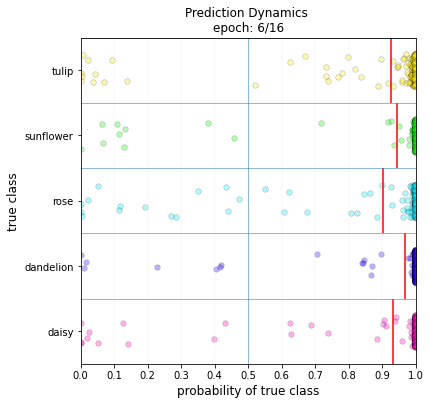

,train_loss,valid_loss,accuracy
5,0.032849,0.201895,0.945602


Better model found at epoch 1 with accuracy value: 0.9027777910232544.
Better model found at epoch 3 with accuracy value: 0.9317129850387573.


epoch,train_loss,valid_loss,accuracy,time
0,0.067603,0.179040,0.942130,00:12
1,0.056952,0.180992,0.947917,00:12
2,0.047479,0.184492,0.950231,00:12
3,0.040138,0.183942,0.950231,00:12
4,0.037787,0.231897,0.934028,00:12
5,0.032849,0.201895,0.945602,00:12
6,0.029196,0.224528,0.938657,00:12


Better model found at epoch 0 with accuracy value: 0.9421296119689941.
Better model found at epoch 1 with accuracy value: 0.9479166865348816.
Better model found at epoch 2 with accuracy value: 0.9502314925193787.
No improvement since epoch 2: early stopping


In [20]:
train_ds, val_ds = ClassificationDataset.from_imagenet(img_dir, 
                                                        [get_light_augmentations(224), val_augmentations(224)])
# plot_sample(train_ds, 5)
dls = DataLoaders.from_dsets(train_ds, val_ds, batch_size=64).cuda()
model = get_model('resnet34d', train_ds.c).cuda()
learn = Learner(dls, model, splitter=default_split, metrics=[accuracy], 
                loss_func=CrossEntropyLossFlat(), cbs=[ImgProcCB()]).to_fp16()
learn.freeze()
lr = learn.lr_find(show_plot=False)
learn.fine_tune(16, base_lr=lr.valley, freeze_epochs=4, 
                cbs=[EarlyStoppingCallback(monitor='accuracy', comp=np.greater, patience=4),
                GradientClip(1.0), PredictionDynamics(),
                SaveModelCallback(monitor='accuracy', comp=np.greater)],)

In [18]:
learn.recorder.metric_names

(#5) ['epoch','train_loss','valid_loss','accuracy','time']

In [18]:
learn.metrics[0].value.item()

0.9432870149612427

In [21]:
learn.smooth_loss.item()

0.015992293134331703

In [37]:
learn._metrics[0].value

TensorBase(0.9456)

In [16]:
dls.enc

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}